In [1]:
#!pip install gym
#!pip install tensorflow[and-cuda]
#!pip install pygame

In [1]:
# set tf warning level to 2 ....shows errors but not warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
#tf.__version__

In [2]:
from gym import Env
from gym.spaces import Discrete, Box

import pandas as pd
import matplotlib.pyplot as plt


import tensorflow as tf
#tf.config.run_functions_eagerly(True)
#print(tf.config.functions_run_eagerly())
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten

# tyr legacy adam due to numpy error
from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.optimizers.legacy import Adam

import numpy as np
import random
import os

import pygame


# get component class from custom module
from component_module import Component, plot_correlation_network, plot_component_comparison, getKDEDensity, getDistributionBins, kde_mutual_information, drop_static_columns, performFourierAndLimitHarmonics, scaler_sec_midnight, save_component, load_component, calculate_phase_and_time_difference

# Set the random seed
seed_value = 44
np.random.seed(seed_value)
random.seed(seed_value)

In [3]:
# Check if TensorFlow is built with CUDA support
if tf.config.list_physical_devices('GPU'):
    print("CUDA is available")
    print(f"Device: {tf.config.list_physical_devices('GPU')[0]}")
else:
    print("CUDA is not available")

CUDA is available
Device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


I0000 00:00:1728137809.524370   79055 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728137809.562961   79055 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728137809.563245   79055 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


# Create Environment

In [4]:
# ubuntu
df_normalised = pd.read_csv("/home/loz/MSc/MSc_Project/SWaT_sec_minmax_22_comps.csv", index_col='time_in_seconds')

data_array = df_normalised.to_numpy()

#df_normalised.shape

In [5]:
#df_normalised

In [6]:
data_array[35].max()

1.0

In [7]:
component_pos = {key: idx for idx, key in enumerate(df_normalised.columns)}
#component_pos.items()

In [8]:
#data_array[component_pos['LIT101']]

In [9]:
#df_comp_files

In [10]:
#path = '/home/loz/Documents/GitHub/MSc-Project/final_code/component_objs/'
path = '/home/loz/MSc/MSc_Project/final_code/component_objs/'


df_comp_files = pd.read_csv(path + 'component_filenames.csv', index_col=0)
components = {}
for component_name, filename in df_comp_files['filename'].items():    
    # put returned component object into dict
    components[component_name] = load_component(filename)
    #print(filename)

Component 'FIT101' has been loaded from /home/loz/MSc/MSc_Project/final_code/component_objs/FIT101.
Component 'LIT101' has been loaded from /home/loz/MSc/MSc_Project/final_code/component_objs/LIT101.
Component 'MV101' has been loaded from /home/loz/MSc/MSc_Project/final_code/component_objs/MV101.
Component 'P101' has been loaded from /home/loz/MSc/MSc_Project/final_code/component_objs/P101.
Component 'P102' has been loaded from /home/loz/MSc/MSc_Project/final_code/component_objs/P102.
Component 'AIT201' has been loaded from /home/loz/MSc/MSc_Project/final_code/component_objs/AIT201.
Component 'AIT202' has been loaded from /home/loz/MSc/MSc_Project/final_code/component_objs/AIT202.
Component 'AIT203' has been loaded from /home/loz/MSc/MSc_Project/final_code/component_objs/AIT203.
Component 'FIT201' has been loaded from /home/loz/MSc/MSc_Project/final_code/component_objs/FIT201.
Component 'MV201' has been loaded from /home/loz/MSc/MSc_Project/final_code/component_objs/MV201.
Component 'P

In [11]:
#components['LIT101'].mutual_info_dict

In [39]:
# test lstm swat simulator
# Load the model from the SavedModel directory
# 20 secs
#swat_lstm = tf.keras.models.load_model('swat_lstm_1_0.keras')

# get single output model
#swat_lstm = tf.keras.models.load_model('swat_lstm_lit101.keras')
# get full 22 component output model
swat_lstm= tf.keras.models.load_model('swat_lstm_22_full_output.keras', compile=False)
model_window = 20

#swat_lstm = tf.keras.models.load_model('swat_lstm_100s.keras')
#model_window = 100



# Agent for single window

In [13]:
# Reshape the input from data_array to add the batch dimension
#reshaped_input = data_array[:model_window-1, :].reshape(1, model_window-1, data_array.shape[1])  # (1, 99, 37)
reshaped_input = data_array[:model_window-1, :].reshape(1, model_window-1, data_array.shape[1])  # (1, 19, 22)
# round to make observation space workable
#reshaped_input = np.round(reshaped_input, 2)


reshaped_input.shape
#reshaped_input[0,-1,]

(1, 19, 22)

# get last row
one_state = reshaped_input[0,-1,:]
one_state.shape

for _ in range(10):
    prediction = swat_lstm.predict(reshaped_input)
    # Print shape
    #print(prediction.shape)
    # drop first row from input, add prediction with new axis padded to match shape
    reshaped_input = np.concatenate((reshaped_input[:, 1:, :], prediction[:, np.newaxis, :]), axis=1)
    #print(reshaped_input.shape)


In [14]:
component_pos

{'P602': 0,
 'LIT301': 1,
 'MV201': 2,
 'FIT101': 3,
 'FIT502': 4,
 'MV101': 5,
 'MV304': 6,
 'P101': 7,
 'FIT301': 8,
 'P301': 9,
 'MV301': 10,
 'P302': 11,
 'MV303': 12,
 'FIT503': 13,
 'LIT401': 14,
 'FIT501': 15,
 'FIT504': 16,
 'P203': 17,
 'MV302': 18,
 'P205': 19,
 'FIT401': 20,
 'LIT101': 21}

In [15]:
data_array.shape

(86400, 22)

# Q Learning Table Implementation

In [41]:
# inherit from gym env
class SwatEnv(Env):
    def __init__(self, data_array, window_size=19, episode_length=100):
        print('init reached')
        # 0: both off, 1: MV101 On MV201 Off, 2: MV101 Off MV201 On, 3: both on
        self.action_space = Discrete(4)
        self.episode_length = episode_length
        
        # make sure array is 3 dims for model input
        if len(data_array.shape) == 2:
            # Add a batch dimension to make it (1, time_steps, features)
            data_array = data_array[np.newaxis, :, :]
        
        # swat value array, only position 1 used as lit101 level. 2.d.p 
        self.observation_space = Box(
            # round to 2 d.p. to act as binning values
            low=np.round(np.full((1, 22), 0.00), 2),  # 1x22 array with all elements set to 0.00
            high=np.round(np.full((1, 22), 100.00), 2),  # 1x22 array with all elements set to 100.00
            dtype=np.float32  # Specify float with two decimal places precision
        )
        
        # Initialise data params
        self.data_array = data_array
        self.window_size = window_size 
        
        # use reset to intialise the data window to use 
        self.reset(data_array)      
        
        # state history is 98 time steps preceding
        #self.state_history = model_input
        # set start state as last row in modelinput
        #elf.state = self.state_history [0,-1,:]
        
        # set shower length
        self.episode_length = episode_length
        
        self.lit101_value_record = []
    
    # Override inherited method  
    def sample_observation(self):
        return np.round(self.observation_space.sample(), 2)

        
    def update_state(self, state_history, action_input):
        # Ensure action_input is reshaped to 1x22 array
        #action_input = action_input.reshape(1, -1)
        
        # add action to previous states
        #model_input = np.concatenate((state_history[:, 1:, :], action_input[:, np.newaxis, :]), axis=1)
        # reshape if needed
        if action_input.ndim == 1:
            action_input = action_input[np.newaxis, np.newaxis, :] 
        if action_input.ndim == 2:
            action_input = action_input[np.newaxis, :, :]  # Shape becomes (1, 1, 22)
    
        # add action to previous states
        model_input = np.concatenate((state_history[:, 1:, :], action_input), axis=1)
         
        
        # predict
        
        new_state = swat_lstm.predict(model_input)
        new_state = np.round(new_state, 2)
        
        # prob don't use as new window wanted
        # update history with new state
        #self.state_history = np.concatenate((state_history[:, 1:, :], new_state[:, np.newaxis, :]), axis=1)
        
        # flatten new_state from (1,37) to (37,)
        new_state = new_state.flatten()
        print(new_state)
        
        return new_state
    
        
    def step(self, action):
        #print(f'step reached {action}')
        
        # copy current state
        action_input = self.state.copy() 
        
        # MV101 
        if action == 0:
            ## MV101 and MV201 off         
            action_input[component_pos['MV101']] = 0
            action_input[component_pos['MV201']] = 0
            
        elif action == 1:
            # MV101 On, MV201 Off
            action_input[component_pos['MV101']] = 1
            action_input[component_pos['MV201']] = 0
        elif action == 2:
            # MV101 Off, MV201 On
            action_input[component_pos['MV101']] = 0
            action_input[component_pos['MV201']] = 1
        elif action == 3:
            # Both MV101 and MV201 On
            action_input[component_pos['MV101']] = 1
            action_input[component_pos['MV201']] = 1

        
        
        new_state = self.update_state(self.state_history, action_input)
        # test with no actions
        #new_state = self.update_state(self.state_history, self.state.copy())
        
        
        #print(new_state.shape, self.state.shape)
        
        #record lit101 state
        #self.lit101_value_record.append((np.round(new_state[component_pos['LIT101']], 2)))
        # get change in value for plotting
        
        # tuple of new and old lit
        self.lit101_value_record.append((np.round(new_state,2), np.round(self.state[component_pos['LIT101']], 2)))

                                     
        # check for increase
        if new_state[component_pos['LIT101']] > self.state[component_pos['LIT101']]:
            reward = new_state[component_pos['LIT101']] - self.state[component_pos['LIT101']]
        elif new_state[component_pos['LIT101']] < self.state[component_pos['LIT101']]:
           reward = new_state[component_pos['LIT101']] - self.state[component_pos['LIT101']] 
     

            
        #print(f'lit:{self.state[component_pos['LIT101']], new_state[component_pos['LIT101']]} reward:{reward}')
        
        # prob not needed as should be reset to new window
        # update state
        #self.state = new_state
        
        done = True
        
        # single episode to allow a new data window
    
        # reduce episode_length
        #self.episode_length = self.episode_length - 1
        
        # Check if episode is done
        #if self.episode_length <= 0:
        #    done = True
        #else:
        #    done = False         
        
        #return self.state, reward, self.lit101_value_record, done #, info
        
        return new_state, reward, self.lit101_value_record, done #, info

    def reset(self, data_array):
        # state history is 98 time steps preceding
        #self.state_history = model_input
        
        # Randomly select new window from data_array for each episode
        start_idx = np.random.randint(0, data_array.shape[1] - self.window_size)
        self.state_history = data_array[:, start_idx:start_idx + self.window_size, :]
        # Set the start state as the last row in the selected window
        self.state = self.state_history[0, -1, :]
        
        # reset episode
        #self.episode_length = episode_length
        # reset value record
        self.lit101_value_record = []
        return self.state
        
    #def render(self):
        # for vis ie pygame
        #pass
    def render(self, screen, font):
        '''
        screen.fill((255, 255, 255))  # Fill the screen with white

        # Draw the temperature meter
        pygame.draw.rect(screen, (0, 0, 255), (100, 150, 50, 200))  # Blue background
        temp_height = (self.state - 0) / 100 * 200  # Scale temp to meter height
        pygame.draw.rect(screen, (255, 0, 0), (100, 350 - temp_height, 50, temp_height))  # Red temperature

        # Display temperature value
        temp_text = font.render(f'Temp: {self.state}°C', True, (0, 0, 0))
        screen.blit(temp_text, (200, 150))

        # Display shower length
        shower_text = font.render(f'Shower Time: {self.shower_length}s', True, (0, 0, 0))
        screen.blit(shower_text, (200, 200))
        '''
        pass

        


In [42]:

#this_env = SwatEnv(data_array, model_window)
#this_env.observation_space
#state_size = this_env.observation_space.shape[1]  #  observation space is (1, 22)
#state_size
#action_size = this_env.action_space.n 
#action_size

In [43]:
bin_size = (1/50)
bin_size

0.02

In [44]:
component_pos['LIT101']

21

# Create Deep Learning Model#


In [97]:


# Deep Q-Network (DQN) class for approximating Q-values
class DQN:
    def __init__(self, state_size, action_size, learning_rate=0.01):
        self.state_size = state_size  # Number of features in the state
        self.action_size = action_size  # Number of possible actions
        self.learning_rate = learning_rate  # Learning rate for the neural network
        
        # Build the neural network model
        self.model = self.build_model()
        
    def build_model(self):
        # Define a neural network architecture
        model = Sequential()
        model.add(Dense(64, input_dim=self.state_size, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))  # Output layer for Q-values
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
                      loss='mse')
        return model
    
    def predict(self, state):
        # Predict Q-values for a given state
        return self.model.predict(state, verbose=0)
    
    def train(self, state, action_rewards, batch_size=1):
        # get existing
        #target = self.model.predict(state.reshape(1,22), verbose=0)
        
        # Predict Q-values for the next state
        #next_q_values = self.model.predict(next_state, verbose=0)
        
        # Train the network on a batch of data
        self.model.fit(state, action_rewards, batch_size=batch_size, verbose=0)


#Run Trials

In [118]:

# add paraam dict here and pass
def run_dqn_trial(environment, data_array, window_size, episodes, q_table=None, batch_size=32, pretrained_model=None, dqn_save_path=None):
    '''
    Function to run agent with a given starting point of a data window from the data_set
    :param environment: SWaTEnv
    :param model_input_window: Random slice of SWaT data in format for LSTM (1,19,37)
    :param number_of_episodes: Times to repeat
    :return: 
    '''
    
    # for debugging
    global dqn_model, state, action_rewards, this_env
    
    # Q learning hyper parameters 
    # learning rate
    alpha = 0.1  
    # Future discount factor
    gamma = 0.9    
    # Initial exploration rate 
    epsilon = 1.0    
    # reduce exploration at each episode
    #epsilon_decay = 0.999
    epsilon_decay = 1
    # final exploration rate/ stochastic behaviour
    min_epsilon = 0.01
    # number of episodes
    episodes = episodes 
    
    # Discrete levels for continuous values, normalised data so range 0-1
    num_bins = 50  
    # get bin size, use 2 to allow for outside of normal range
    bin_size = (1.2/num_bins)
    
    
    #this_env = environment(data_array, window_size, episode_length)
    # env is reset after every episode so no internal counter
    this_env = environment(data_array, window_size)
    
    # set values for dqn with parameters from env
    state_size = this_env.observation_space.shape[1]  #  observation space is (1, 22)
    action_size = this_env.action_space.n 
    
    
    # Initialise or load the dqn
    if pretrained_model:
        print("Loading pre-trained model...")
        dqn_model = pretrained_model  # Use the provided pre-trained model
    else:
        print("Initializing new model...")
        dqn_model = DQN(state_size, action_size)  # Create a new DQN model if no pre-trained model is provided
    
    
    #intitalise with zeros if one not passed
    if q_table is None:
        # Initialise Q-table with zeros, dims: number of possible states * number of actions
        q_table = np.zeros((num_bins, this_env.action_space.n))
    
    # make sure array is 3 dims for model input
    if len(data_array.shape) == 2:
        # Add a batch dimension to make it (1, time_steps, features)
        data_array = data_array[np.newaxis, :, :]
        
        

    
    # store lit101 values form each episode
    #lit101_list = []
    
    # target variable
    target_loc = component_pos['LIT101']
    
    
    lit101_list = []
    
    
    #episodes = episode_length
    for episode in range(1, episodes+1):
        
        this_env.reset(data_array)
        state = this_env.state
        # just to initialise
        n_state = this_env.state
        #print(n_state)
        
        state_idx = int(np.round((n_state[target_loc]/ bin_size),2))
        done = False
        score = 0 
        
        while not done:
            #env.render()
            # sample from 4 possible states 
            
            # compare epsilon to random number, as epsilon decreases chance of random exploration decreases 
            if np.random.uniform(0, 1) < epsilon:
                # heuristic to prioritise MV101 and speed up convergence
                #action_probabilities = [0.2, 0.4, 0.2, 0.2]
                #action = np.random.choice(len(action_probabilities), p=action_probabilities)
                
                # get q reward for all possible actions and format for dqn
                action_rewards = []
                for action in range(action_size):
                    new_state, reward, value_change, done = this_env.step(action)
                    action_rewards.append(reward)
                    
                # lsit to array for dqn
                action_rewards = np.array(action_rewards).reshape(1, action_size)
                # fit model 
                dqn_model.train(state.reshape(1,22), action_rewards)
                
                # test with predict
                dqn_output = dqn_model.predict(state.reshape(1,22))
                
                # random explore
                action = this_env.action_space.sample()
            else:
                # take best action for this state for q table
                # deliberate exploit
                action = np.argmax(q_table[state_idx]) 
                
                # use dqn 
                #q_values = dqn_model.predict(state)
                
            # force action    
            # just activate MV101 to see if response from lstm model is linear
            #action = 1
            
            # pass 1 x 37 array of SWat states
            #action = one_state
            #n_state, reward, done, info = env.step(action)
            
            # q table verison, moved to loop
            new_state, reward, value_change, done = this_env.step(action)
            lit101_list.append(value_change)
            # bin new state of target variable
            #target_state_idx = int(np.round((n_state[target_loc]// bin_size),2))
            target_state_idx = int(np.round((new_state[component_pos['LIT101']]// bin_size),2))
            
            # test dqn
            #dqn_output = dqn_model.predict(state.reshape(1,22))
            #print(f'dqn_output:{dqn_output}')
            
            # train dqn
            #dqn_model.train()
            
            # check lit is in range
            if  0 <= new_state[component_pos['LIT101']] <= 1:
                # Q-learning update rule
                
                # with discount of distance from final goal
                #q_table[state_idx, action] = q_table[state_idx, action] + alpha * (
                #reward + gamma * np.max(q_table[target_state_idx]) - q_table[state_idx, action]
                #)
                
                q_table[state_idx, action] = q_table[state_idx, action] + alpha * ( reward )
            
            #print(n_state)
            score+=reward
        #print('Episode:{} Score:{}'.format(episode, score))
        # add this episodes list of values
        #lit101_list = this_env.lit101_value_record
        
        # reduce exploration factor
        epsilon = max(min_epsilon, epsilon * epsilon_decay)
    return lit101_list, q_table
    
    
    #return input_windows


In [129]:
# q table at each 2000 episodes
#q_table_list = []
#q_table_list.append(q_table)

In [152]:
for _ in range(10):
    if q_table_list:
        q_table = q_table_list[-1].copy()
        lit101_li, q_table= run_dqn_trial(SwatEnv,data_array,model_window, 200, q_table, pretrained_model=dqn_model)
        q_table_list.append(q_table)
    else:
        lit101_li, q_table = run_dqn_trial(SwatEnv,data_array,model_window, 200)
        q_table_list.append(q_table)
    

init reached
Loading pre-trained model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[0.01 0.65 0.07 0.87 0.58 0.01 0.11 0.78 0.81 0.28 0.71 0.37 0.22 1.02
 0.75 0.35 0.24 0.75 0.59 1.12 0.13 0.32]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[-0.    0.75  0.06  0.81  0.61  0.81  0.13  0.77  0.88  0.33  0.62  0.41
  0.25  1.07  0.82  0.35  0.27  0.78  0.58  1.07  0.21  0.36]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[0.06 0.7  0.65 1.02 0.67 0.01 0.12 0.82 0.87 0.22 0.58 0.37 0.28 1.01
 0.77 0.28 0.22 0.7  0.43 1.08 0.18 0.27]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[0.04 0.78 0.73 1.02 0.61 0.87 0.13 0.83 0.84 0.24 0.55 0.42 0.31 1.04
 0.77 0.26 0.23 0.71 0.42 1.04 0.26 0.3 ]


/home/loz/MSc/MSc_Project/venv/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[0.04 0.78 0.73 1.02 0.61 0.87 0.13 0.83 0.84 0.24 0.55 0.42 0.31 1.04
 0.77 0.26 0.23 0.71 0.42 1.04 0.26 0.3 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[-0.11  0.34 -0.03 -0.02  0.44  0.21 -0.03  0.    0.9   0.09  0.33  0.5
  0.05  1.02  0.47  0.59  0.28  0.05  0.63  0.09  0.35  1.14]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[-0.14  0.4  -0.06 -0.03  0.41  0.67 -0.03 -0.04  0.9   0.14  0.37  0.52
  0.06  1.01  0.46  0.56  0.26  0.09  0.67  0.11  0.45  1.1 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[-0.16  0.36  0.45  0.12  0.51  0.18 -0.04  0.03  0.9   0.02  0.4   0.57
  0.04  0.98  0.38  0.56  0.23  0.01  0.49  0.12  0.43  1.17]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[-0.19  0.44  0.44  0.12  0.49  0.65 -0.03 -0.02  0.89  0.09  0.41  0.56
  0.01  0.98  0.37  0.56  0.2   0.04  0.54  0.15  0.53  1.11]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[-0.19  0.44  0.44  0.12  0.49  0.65 -0.03 -0.02  0.89  0.09  0.41  0.56
  0.01  0.98  0.37  0.56  0.2   0.04  0.54  0.1

In [164]:
#dqn_model.save('dqn_model_li1101_4action.keras')
#swat_lstm_lit = tf.keras.models.load_model('swat_lstm_22_full_output.keras', compile=False)

In [153]:
action_rewards

array([[0.24445889, 0.30445889, 0.18445892, 0.21445892]])

In [157]:
#dqn_model.train(state.reshape(1,22), action_rewards)
                
# test with predict
dqn_output = dqn_model.predict(state.reshape(1,22))
dqn_output

array([[0.25917485, 0.31643444, 0.20278567, 0.21931973]], dtype=float32)

In [160]:
# plot 100 sample windo
num_samples = 1000 
num_features = data_array.shape[1]
num_actions = dqn_model.action_size  


prediction_data = data_array[:num_samples].reshape(num_samples, num_features)

# Predict Q-values with dqn
predicted_q_values = dqn_model.predict(prediction_data)



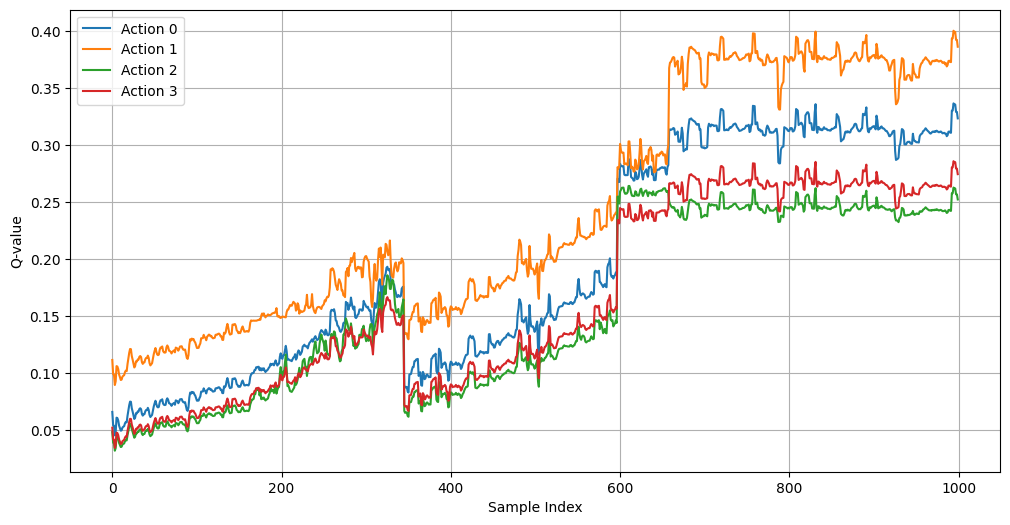

In [161]:
plt.figure(figsize=(12, 6))
# Plot Q-values for each action
for action in range(num_actions):
    plt.plot(predicted_q_values[:, action], label=f'Action {action}')

plt.xlabel('Sample Index')
plt.ylabel('Q-value')
plt.legend()
plt.grid(True)  

plt.savefig('/home/loz/MSc/MSc_Project/Write_Up/Charts/dqn_lit101_2000_samples.jpeg')
plt.show()

In [133]:

data =q_table_list[-1]


In [134]:
data[0:,:]

array([[ 4.41334055e-01,  3.51825164e-01,  3.00221095e-01,
         2.73525467e-01],
       [ 1.59220884e+00,  1.53712805e+00,  1.26806845e+00,
         1.27708401e+00],
       [ 1.33431337e+00,  1.51313750e+00,  1.12299845e+00,
         9.98070994e-01],
       [ 1.71369395e+00,  1.88425161e+00,  1.56700901e+00,
         1.35685589e+00],
       [ 1.99700078e+00,  2.06325998e+00,  1.28935044e+00,
         1.14778321e+00],
       [ 1.15718871e+00,  1.20989046e+00,  7.71546737e-01,
         7.01063977e-01],
       [ 2.03260344e-01,  3.09410217e-01,  1.40593242e-01,
         9.88655687e-02],
       [-2.08074123e-02,  1.77681405e-02, -1.07394786e-05,
         5.20986699e-02],
       [ 2.59761589e-02,  3.58834634e-02,  2.41545474e-02,
         3.22770053e-02],
       [ 1.64494085e-02,  4.86063815e-02,  1.60725030e-02,
         1.24244800e-02],
       [ 3.65719233e-02,  1.43160479e-01, -9.22596584e-03,
         2.55076985e-02],
       [ 1.36884304e-02,  2.35219802e-02,  1.20083105e-02,
      

In [135]:
len(q_table_list)

10

In [136]:
q_table_list

[array([[ 2.88240056e-02,  9.29238889e-02,  0.00000000e+00,
          0.00000000e+00],
        [ 1.32857274e-01,  9.28834614e-02,  7.44197127e-02,
          1.51521995e-01],
        [ 1.01934574e-01, -3.92630359e-03,  1.48410218e-01,
          1.37755008e-01],
        [ 6.29131708e-02,  3.42482650e-01,  1.29620620e-01,
          1.00324612e-01],
        [ 2.32783533e-01,  3.03354259e-01,  1.56609931e-01,
          1.47494575e-01],
        [ 3.88525287e-02,  7.96111448e-02,  2.59429238e-02,
          4.94875200e-02],
        [ 6.75625352e-03,  5.56801329e-02,  3.93376581e-02,
          0.00000000e+00],
        [-4.13438700e-03,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.90487402e-02],
        [-1.08668486e-02,  0.00000000e+00, -1.27098691e-02,
          2.18252149e-02],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          2.39108277e-02],
        [ 1.49345778e-02,  0.00000000e+00, 

In [137]:
action_mean = np.array(np.mean(q_table_list[-3], axis=0) )
action_mean                    

array([0.13407324, 0.15734426, 0.09957651, 0.09251684])

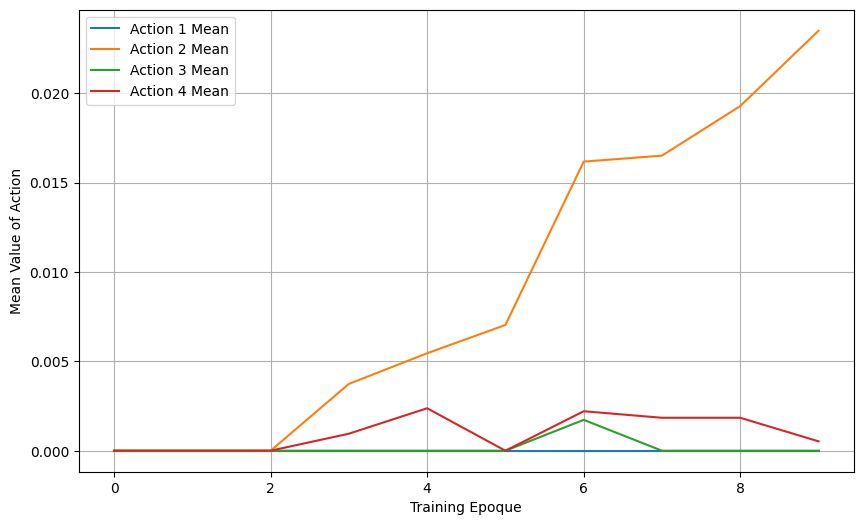

In [138]:

# Assuming q_table_list is a list of 100 Q-tables, each with shape (50, 4)
# For example: q_table_list[0].shape == (50, 4)

# Calculate the mean value of each action column for each Q-table
action_means = np.array([np.median(q_table, axis=0) for q_table in q_table_list])  # Shape: (100, 4)

# Create a plot
plt.figure(figsize=(10, 6))

# Plot the mean value of each action across all 100 Q-tables
for action_idx in range(action_means.shape[1]):  # There are 4 action columns
    plt.plot(action_means[:, action_idx], label=f'Action {action_idx + 1} Mean')

# Add labels, title, and legend
plt.xlabel('Training Epoque')
plt.ylabel('Mean Value of Action')

plt.legend()
plt.grid(True)
plt.savefig('/home/loz/MSc/MSc_Project/Write_Up/Charts/lit_basic_q_table.jpeg')
# Show the plot
plt.show()

In [139]:
action_means

array([[0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.00373958, 0.        , 0.00095243],
       [0.        , 0.00545539, 0.        , 0.0023775 ],
       [0.        , 0.00703804, 0.        , 0.        ],
       [0.        , 0.01617956, 0.00172771, 0.00220983],
       [0.        , 0.01651545, 0.        , 0.00184419],
       [0.        , 0.01929191, 0.        , 0.00184419],
       [0.        , 0.02350591, 0.        , 0.00052496]])

In [140]:
lit101_li

[[(array([ 0.04,  0.3 , -0.  ,  0.23,  0.54,  0.15,  0.08,  0.67,  0.91,
           0.16,  0.59,  0.37,  0.22,  1.06,  0.61,  0.42,  0.29,  0.72,
           0.53,  0.17,  0.1 ,  0.97], dtype=float32),
   0.97),
  (array([ 0.03,  0.41, -0.01,  0.22,  0.52,  0.77,  0.09,  0.66,  0.96,
           0.22,  0.62,  0.36,  0.22,  1.13,  0.67,  0.36,  0.31,  0.78,
           0.54,  0.15,  0.15,  1.  ], dtype=float32),
   0.97),
  (array([0.1 , 0.31, 0.45, 0.34, 0.62, 0.1 , 0.09, 0.7 , 1.01, 0.1 , 0.6 ,
          0.38, 0.26, 1.11, 0.57, 0.34, 0.28, 0.76, 0.38, 0.1 , 0.17, 0.94],
         dtype=float32),
   0.97),
  (array([0.11, 0.35, 0.46, 0.32, 0.58, 0.84, 0.11, 0.69, 1.01, 0.13, 0.65,
          0.36, 0.26, 1.14, 0.59, 0.29, 0.28, 0.8 , 0.37, 0.12, 0.17, 0.95],
         dtype=float32),
   0.97),
  (array([ 0.04,  0.3 , -0.  ,  0.23,  0.54,  0.15,  0.08,  0.67,  0.91,
           0.16,  0.59,  0.37,  0.22,  1.06,  0.61,  0.42,  0.29,  0.72,
           0.53,  0.17,  0.1 ,  0.97], dtype=float32),
 

In [141]:
data = data[~np.all(data == 0, axis=1)]
data[-1]

array([-0.03081333, -0.0422711 , -0.00703685, -0.03032584])

/tmp/ipykernel_79055/614373394.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


FileNotFoundError: [Errno 2] No such file or directory: '/home/loz/Documents/GitHub/MSc-Project/Write_Up/Charts/basic_q_best_action.jpeg'

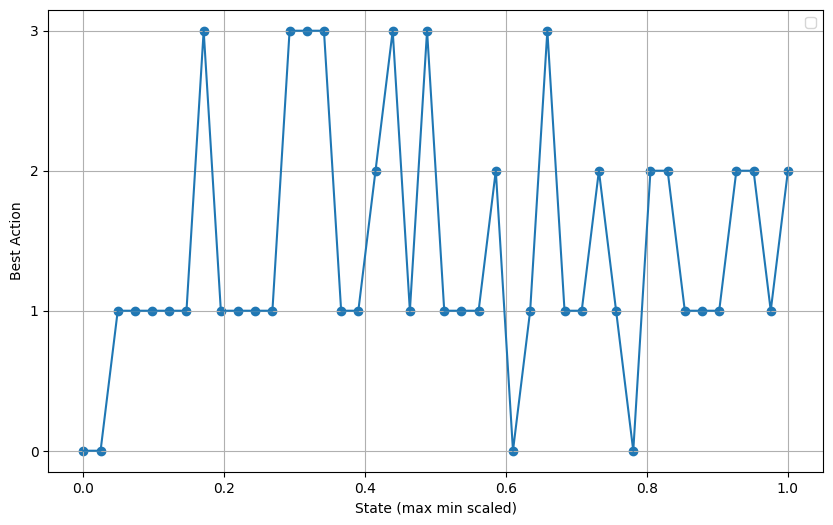

In [142]:

max_indices = np.argmax(data, axis=1)

# Create x values scaled between 0 and 1
total_rows = len(data)  # Total number of rows in the data
x_values = np.linspace(0, 1, total_rows)  # Generate values from 0 to 1

plt.figure(figsize=(10, 6))
plt.scatter(x_values, max_indices)
plt.plot(x_values, max_indices)
plt.xlabel('State (max min scaled)')
plt.ylabel('Best Action')
plt.yticks(np.arange(data.shape[1])) 
plt.grid(True)
plt.legend()

plt.savefig('/home/loz/Documents/GitHub/MSc-Project/Write_Up/Charts/basic_q_best_action.jpeg')

# Show the plot
plt.show()

In [143]:
q_table_list


[array([[ 2.88240056e-02,  9.29238889e-02,  0.00000000e+00,
          0.00000000e+00],
        [ 1.32857274e-01,  9.28834614e-02,  7.44197127e-02,
          1.51521995e-01],
        [ 1.01934574e-01, -3.92630359e-03,  1.48410218e-01,
          1.37755008e-01],
        [ 6.29131708e-02,  3.42482650e-01,  1.29620620e-01,
          1.00324612e-01],
        [ 2.32783533e-01,  3.03354259e-01,  1.56609931e-01,
          1.47494575e-01],
        [ 3.88525287e-02,  7.96111448e-02,  2.59429238e-02,
          4.94875200e-02],
        [ 6.75625352e-03,  5.56801329e-02,  3.93376581e-02,
          0.00000000e+00],
        [-4.13438700e-03,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.90487402e-02],
        [-1.08668486e-02,  0.00000000e+00, -1.27098691e-02,
          2.18252149e-02],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          2.39108277e-02],
        [ 1.49345778e-02,  0.00000000e+00, 

In [ ]:
np.savez('/home/loz/Documents/GitHub/MSc-Project/final_code/component_objs/q_table_list_2000s.npz', *q_table_list) 

# Visualise Q Table COnvergence

In [ ]:
# Load the .npz file
file_path = '/home/loz/Documents/GitHub/MSc-Project/final_code/component_objs/q_table_list_2000s.npz'
data = np.load(file_path)

In [ ]:
# Find largest non zero array
max_rows, max_cols = 0, 0
for key in data.files:
    array = data[key]
    non_zero_indices = np.nonzero(array)
    if len(non_zero_indices[0]) > 0 and len(non_zero_indices[1]) > 0:
        max_row = max(non_zero_indices[0]) + 1
        max_col = max(non_zero_indices[1]) + 1
        if max_row > max_rows:
            max_rows = max_row
        if max_col > max_cols:
            max_cols = max_col

# Store the trimmed arrays
trimmed_arrays = {}

# Trim array 
for key in data.files:
    array = data[key]
    trimmed_array = array[:max_rows, :max_cols]
    trimmed_arrays[key] = trimmed_array

In [ ]:
data = trimmed_arrays

In [ ]:
data = trimmed_arrays
np.savez('/home/loz/Documents/GitHub/MSc-Project/final_code/component_objs/q_table_list_2000s.npz', data) 

In [ ]:
file_path = '/home/loz/Documents/GitHub/MSc-Project/final_code/component_objs/q_table_list_2000s.npz'
data = np.load(file_path, allow_pickle=True)

In [ ]:
data

In [ ]:

# best actions 
best_actions_list = []

for q_table in data.values():
    # get best action
    if isinstance(q_table, np.ndarray) and q_table.ndim == 2:
        best_actions = np.argmax(q_table, axis=1)
        best_actions_list.append(best_actions)
        
best_actions_array = np.array(best_actions_list)

# Calculate the mean and standard deviation 
mean_best_actions = np.mean(best_actions_array, axis=0)
std_best_actions = np.std(best_actions_array, axis=0)

# get rid of bins
x_values = (np.arange(len(mean_best_actions)) * 4) / 100

# Plot the mean best action
plt.figure(figsize=(12, 8))
plt.plot(x_values, mean_best_actions, label='Mean Best Action Index', color='blue', linewidth=2)

# Fill between mean and std 
plt.fill_between(x_values, 
                 mean_best_actions - std_best_actions, 
                 mean_best_actions + std_best_actions, 
                 color='blue', alpha=0.2, label='Standard Deviation')

# Customize the plot
#plt.title('General Trend of Best Actions')
plt.xlabel('State')
plt.ylabel('Best Action')
plt.yticks([0, 1, 2, 3])
plt.xlim(0, 1)
plt.legend(loc='best')
plt.grid(True)
plt.savefig('/home/loz/Documents/GitHub/MSc-Project/Write_Up/Charts/basic_q_best_action.jpeg')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Extract the best actions from each Q-table and collect them into a list
best_actions_list = []

for q_table in data.values():
    if isinstance(q_table, np.ndarray) and q_table.ndim == 2:
        # Calculate the best action for each state (highest value in the row)
        best_actions = np.argmax(q_table, axis=1)
        best_actions_list.append(best_actions)

# Convert the list of best actions to a numpy array (shape: [num_q_tables, num_states])
best_actions_array = np.array(best_actions_list)

# Calculate the mean best action index across Q-tables for each state
mean_best_actions = np.mean(best_actions_array, axis=0)

# Plot the mean best action index over time
plt.figure(figsize=(12, 8))
plt.plot(mean_best_actions, label='Mean Best Action Index', color='blue', linewidth=2)

# Optionally, plot the median for a more robust trend line
median_best_actions = np.median(best_actions_array, axis=0)
plt.plot(median_best_actions, label='Median Best Action Index', color='orange', linestyle='--', linewidth=2)

# Customize the plot
plt.title('General Trend of Best Actions Across Q-Tables Over Time')
plt.xlabel('State (Time Step)')
plt.ylabel('Mean/Median Best Action Index')
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [ ]:
q_table.shape

In [ ]:
# Set NumPy print options to display the full array
np.set_printoptions(threshold=np.inf)

In [ ]:
print(q_table)

In [ ]:
lit101_list = []
for _ in range(100):
    lit101_li,  q_table  = run_trial(SwatEnv,data_array,model_window,1)
    lit101_list.append(lit101_li)

In [ ]:
lit101_list

In [ ]:
lit101_list_ac1 = lit101_list.copy()

In [ ]:
lit101_list_ac5

In [ ]:
lit101_list

In [ ]:
self.lit101_value_record.

In [ ]:
input_windows.keys()

In [ ]:
trial_window = input_windows[0]

trial_window[0,-1,36]


In [ ]:
# final value for lit
for key,window in input_windows.items():
    print(window[0,-1,:][component_pos['LIT101']])

In [ ]:
#for key, value in values_dict.items():
#plt.plot(lit101_list_ac1, label=f'Episode {key}')
    #for item in value:
plt.plot(lit101_list, label='Action 1')
plt.plot(lit101_list, label= 'Action 5')

plt.xscale('log')
plt.xlabel('Time Steps')
plt.ylabel('LIT101 Level')
plt.title('LIT101 with MV101 On')
plt.legend(loc='lower right')
plt.savefig('/home/loz/Documents/GitHub/MSc-Project/Write_Up/Charts/MV101_held_high.jpeg')
#plt.savefig('/home/loz/Documents/GitHub/MSc-Project/Write_Up/Charts/LIT101_no_actions.jpeg')
plt.show()




# Create Deep Policy Table

# Create Deep Learning Model#

In [ ]:
states = env.observation_space.shape
actions = env.action_space.n

In [ ]:
states

In [ ]:
actions

In [ ]:
def build_model(states, actions):
    model = Sequential()    
    model.add(Dense(24, activation='relu', input_shape=states))
    #model.add(Dense(24, activation='relu', input_shape=(1,)))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [ ]:
#del model

In [ ]:
model = build_model(states, actions)

In [ ]:
model.summary()

# Build Agent wit Keras-RL

In [ ]:
#@tf.function(reduce_retracing=True)
def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy,
                  nb_actions=actions, nb_steps_warmup=10, target_model_update=1e-2)
    return dqn

In [ ]:
dqn = build_agent(model, actions)

In [ ]:
dqn.compile(Adam(learning_rate=1e-3), metrics=['mae'])

In [ ]:


dqn.fit(env, nb_steps=5000, visualize=False, verbose=1)


In [ ]:
scores = dqn.test(env, nb_episodes=100, visualize=False)
print(np.mean(scores.history['episode_reward']))

In [ ]:
os.getcwd()

In [ ]:
#os.listdir()

In [ ]:
# get pre_trained model of SWaT
swat_lstm = tf.keras.models.load_model('swat_lstm_100s.keras')
